In [3]:
import torch
import torch.nn as nn
import numpy as np

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.empty_cache()

In [4]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)
    return train_data, train_label, test_data, test_label

train_data, train_label, test_data, test_label = read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [5]:
import torch.utils.data as Data
train_data_t = torch.from_numpy(train_data).cuda()
train_label_t = torch.from_numpy(train_label).cuda()
train_dataset = Data.TensorDataset(train_data_t,train_label_t)
train_dataloader = Data.DataLoader(train_dataset,batch_size=64,shuffle=True)

test_data_t = torch.from_numpy(test_data).cuda()
test_label_t = torch.from_numpy(test_label).cuda()
test_dataset = Data.TensorDataset(test_data_t,test_label_t)
test_dataloader = Data.DataLoader(test_dataset,batch_size=64,shuffle=True)


In [6]:
class EEGNet_elu(nn.Module):
    def __init__(self):
        super(EEGNet_elu, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
        self.depthwiseconv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1,1), groups=16,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableconv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)        
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
            )    

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseconv(x)
        x = self.separableconv(x)
        x = x.view(x.size(0), -1) 
        output =  self.classify(x)
        return output
    
class EEGNet_relu(nn.Module):
    def __init__(self):
        super(EEGNet_relu, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
        self.depthwiseconv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1,1), groups=16,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableconv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)        
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
            )    

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseconv(x)
        x = self.separableconv(x)
        x = x.view(x.size(0), -1) 
        output =  self.classify(x)
        return output
    
class EEGNet_leakyrelu(nn.Module):
    def __init__(self):
        super(EEGNet_leakyrelu, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
        self.depthwiseconv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1,1), groups=16,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.1),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableconv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.1),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)        
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
            )    

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseconv(x)
        x = self.separableconv(x)
        x = x.view(x.size(0), -1) 
        output =  self.classify(x)
        return output

In [7]:
Batch_size =64
Learning_rate=1e-2
Epochs =350
Results = {}

In [14]:
torch.cuda.empty_cache()
eegnet = EEGNet_elu().cuda()
Optimizer = torch.optim.Adam(eegnet.parameters(), lr=Learning_rate)
Loss_func = nn.CrossEntropyLoss()

test_label_t = test_label_t.long().cuda()
#Optimizer
eegnet = eegnet.double()
test_result = []
train_result = []
for epoch in range(Epochs):
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        b_x = b_x.cuda()
        output = eegnet(b_x)            
        b_y = b_y.long().cuda()
        loss = Loss_func(output, b_y)   
        s1 =  torch.squeeze(b_y)
        s2 =  torch.squeeze(output)
        Optimizer.zero_grad()          
        loss.backward()                
        Optimizer.step()              
    
    test_output = eegnet(test_data_t)
    pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze() 
    accuracy = float(torch.sum(pred_y == test_label_t)) /test_label_t.size(0)
    test_result.append(accuracy)
    if(epoch%30==0):
        print(epoch)
        print("TEST  data:",accuracy )
    
    train_output = eegnet(train_data_t)
    pred_y = torch.max(train_output, 1)[1].cuda().data.squeeze() 
    pred_y = pred_y.double()
    accuracy = float(torch.sum(pred_y == train_label_t)) /test_label_t.size(0)
    train_result.append(accuracy)
    if(epoch%(Epochs/5)==0):
        print("TRAIN data:",accuracy)    
Results['EEG_test_elu'] = test_result
Results['EEG_train_elu'] = train_result

0
TEST  data: 0.6851851851851852
TRAIN data: 0.7166666666666667
30
TEST  data: 0.7268518518518519
60
TEST  data: 0.7620370370370371
TRAIN data: 0.9166666666666666
90
TEST  data: 0.7638888888888888
120
TEST  data: 0.7592592592592593
TRAIN data: 0.9564814814814815
150
TEST  data: 0.7537037037037037
180
TEST  data: 0.7833333333333333
210
TEST  data: 0.7824074074074074
TRAIN data: 0.975
240
TEST  data: 0.7787037037037037
270
TEST  data: 0.775
TRAIN data: 0.9851851851851852
300
TEST  data: 0.7657407407407407
330
TEST  data: 0.7592592592592593


In [15]:
eegnet = EEGNet_relu().cuda()
Optimizer = torch.optim.Adam(eegnet.parameters(), lr=Learning_rate)   # optimize all cnn parameters
Loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

test_label_t = test_label_t.long().cuda()
#Optimizer
eegnet = eegnet.double()
test_result = []
train_result = []
for epoch in range(Epochs):
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        b_x = b_x.cuda()
        output = eegnet(b_x)               # cnn output
        b_y = b_y.long().cuda()
        loss = Loss_func(output, b_y)   # cross entropy loss
        s1 =  torch.squeeze(b_y)
        s2 =  torch.squeeze(output)
        Optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        Optimizer.step()                # apply gradients
    
    test_output = eegnet(test_data_t)
    pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze() 
    accuracy = float(torch.sum(pred_y == test_label_t)) /test_label_t.size(0)
    test_result.append(accuracy)
    if(epoch%(Epochs/5)==0):
        print(epoch)
        print("TEST  data:",accuracy )
    
    train_output = eegnet(train_data_t)
    pred_y = torch.max(train_output, 1)[1].cuda().data.squeeze() 
    pred_y = pred_y.double()
    accuracy = float(torch.sum(pred_y == train_label_t)) /test_label_t.size(0)
    train_result.append(accuracy)
    if(epoch%(Epochs/5)==0):
        print("TRAIN data:",accuracy)    
Results['EEG_test_relu'] = test_result
Results['EEG_train_relu'] = train_result

0
TEST  data: 0.6944444444444444
TRAIN data: 0.7305555555555555
70
TEST  data: 0.8074074074074075
TRAIN data: 0.9796296296296296
140
TEST  data: 0.8037037037037037
TRAIN data: 0.9851851851851852
210
TEST  data: 0.8222222222222222
TRAIN data: 0.987037037037037
280
TEST  data: 0.8185185185185185
TRAIN data: 0.9935185185185185


In [16]:
eegnet = EEGNet_leakyrelu().cuda()
Optimizer = torch.optim.Adam(eegnet.parameters(), lr=Learning_rate)   # optimize all cnn parameters
Loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

test_label_t = test_label_t.long().cuda()
#Optimizer
eegnet = eegnet.double()
test_result = []
train_result = []
for epoch in range(Epochs):
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        b_x = b_x.cuda()
        output = eegnet(b_x)           
        b_y = b_y.long().cuda()  
        loss = Loss_func(output, b_y)   
        s1 =  torch.squeeze(b_y)
        s2 =  torch.squeeze(output)
        Optimizer.zero_grad() 
        loss.backward()
        Optimizer.step()
    
    test_output = eegnet(test_data_t)
    pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze() 
    accuracy = float(torch.sum(pred_y == test_label_t)) /test_label_t.size(0)
    test_result.append(accuracy)
    if(epoch%(Epochs/3)==0):
        print(epoch)
        print("TEST  data:",accuracy )
    
    train_output = eegnet(train_data_t)
    pred_y = torch.max(train_output, 1)[1].cuda().data.squeeze() 
    pred_y = pred_y.double()
    accuracy = float(torch.sum(pred_y == train_label_t)) /test_label_t.size(0)
    train_result.append(accuracy)
    if(epoch%(Epochs/3)==0):
        print("TRAIN data:",accuracy)    
Results['EEG_test_leakyrelu'] = test_result
Results['EEG_train_leakyrelu'] = train_result

0
TEST  data: 0.7101851851851851
TRAIN data: 0.737037037037037


EEG_test_elu         0.8
EEG_train_elu         0.9953703703703703
EEG_test_relu         0.8379629629629629
EEG_train_relu         0.9981481481481481
EEG_test_leakyrelu         0.8212962962962963
EEG_train_leakyrelu         0.9953703703703703


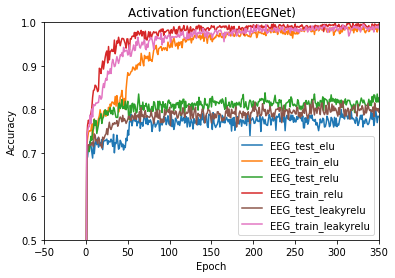

In [50]:
import numpy as np
import matplotlib.pyplot as plt

for i in Results:
    print(i,"       ",max(Results[i]))
# plot the data
fig = plt.figure()
x = np.arange(0, 351, 1)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, Results['EEG_test_elu'], color='tab:blue',label='EEG_test_elu')
ax.plot(x, Results['EEG_train_elu'], color='tab:orange',label='EEG_train_elu')
ax.plot(x, Results['EEG_test_relu'], color='tab:green',label='EEG_test_relu')
ax.plot(x, Results['EEG_train_relu'], color='tab:red',label='EEG_train_relu')
ax.plot(x, Results['EEG_test_leakyrelu'], color='tab:brown',label='EEG_test_leakyrelu')
ax.plot(x, Results['EEG_train_leakyrelu'], color='tab:pink',label='EEG_train_leakyrelu')
# set the limits
ax.set_xlim([-50, 350])
ax.set_ylim([0.5, 1])

ax.set_title('Activation function(EEGNet)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
# display the plot
plt.show()

In [8]:
from functools import reduce
class DeepConvNet_elu(nn.Module):
    def __init__(self, deepconv=[25,50,100,200]):
        super(DeepConvNet_elu, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.Conv2d(25, 25, kernel_size=(2, 1), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)     
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)     
        )
        self.classify = nn.Sequential(
            nn.Softmax()
            )
        flatten_size =  200 * reduce(
            lambda x,_: round((x-4)/2), deepconv, 750)
        self.classify2 = nn.Sequential(
            nn.Linear(flatten_size, 2, bias=True),
            )  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, self.classify2[0].in_features)
        #print(x.shape)
        output =  self.classify2(x)
        #print(output.shape)
        return output
    

class DeepConvNet_relu(nn.Module):
    def __init__(self, deepconv=[25,50,100,200]):
        super(DeepConvNet_relu, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.Conv2d(25, 25, kernel_size=(2, 1), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)     
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)     
        )
        self.classify = nn.Sequential(
            nn.Softmax()
            )
        flatten_size =  200 * reduce(
            lambda x,_: round((x-4)/2), deepconv, 750)
        self.classify2 = nn.Sequential(
            nn.Linear(flatten_size, 2, bias=True),
            )  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, self.classify2[0].in_features)
        #print(x.shape)
        output =  self.classify2(x)
        #print(output.shape)
        return output    
    
class DeepConvNet_leakyrelu(nn.Module):
    def __init__(self, deepconv=[25,50,100,200]):
        super(DeepConvNet_leakyrelu, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.Conv2d(25, 25, kernel_size=(2, 1), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)     
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), stride=(1,1), padding=(0,0), bias=True),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)     
        )
        self.classify = nn.Sequential(
            nn.Softmax()
            )
        flatten_size =  200 * reduce(
            lambda x,_: round((x-4)/2), deepconv, 750)
        self.classify2 = nn.Sequential(
            nn.Linear(flatten_size, 2, bias=True),
            )  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, self.classify2[0].in_features)
        #print(x.shape)
        output =  self.classify2(x)
        #print(output.shape)
        return output    



In [9]:
depconvnet = DeepConvNet_elu().cuda()
Optimizer = torch.optim.Adam(depconvnet.parameters(), lr=Learning_rate) 
Loss_func = nn.CrossEntropyLoss()  
test_label_t = test_label_t.long().cuda()
#Optimizer
Optimizer.zero_grad()
depconvnett = depconvnet.double()
test_result = [0]
train_result = [0]
for epoch in range(Epochs):
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        b_x = b_x.cuda()
        output = depconvnet(b_x)
        b_y = b_y.long().cuda()
        loss = Loss_func(output, b_y)   
        s1 =  torch.squeeze(b_y)
        s2 =  torch.squeeze(output)
        Optimizer.zero_grad()         
        loss.backward()               
        Optimizer.step()
    
    a = 0
    b = 0
    for step, (b_x, b_y) in enumerate(test_dataloader):
        pred_y = depconvnet(b_x) 
        pred_y = torch.max(pred_y, 1)[1].cuda().data.squeeze() 
        pred_y = pred_y.double()
        a += float(torch.sum(pred_y == b_y)) 
        b += pred_y.size(0)
    test_result.append(a/b)
    a = 0
    b = 0
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        pred_y = depconvnet(b_x) 
        pred_y = torch.max(pred_y, 1)[1].cuda().data.squeeze() 
        pred_y = pred_y.double()
        a += float(torch.sum(pred_y == b_y))
        b += pred_y.size(0)
    train_result.append(a/b)
    if(epoch%30==0):
        print(epoch,test_result[-1],train_result[-1])

        
Results['DeepConvNet_train_elu'] = train_result
Results['DeepConvNet_test_elu'] = test_result
  

0 0.6333333333333333 0.6472222222222223
30 0.7157407407407408 0.8046296296296296
60 0.7518518518518519 0.862037037037037
90 0.737037037037037 0.9074074074074074
120 0.7425925925925926 0.937962962962963
150 0.7768518518518519 0.937962962962963
180 0.7592592592592593 0.9287037037037037
210 0.7388888888888889 0.95
240 0.7509259259259259 0.9648148148148148
270 0.7555555555555555 0.9537037037037037
300 0.7305555555555555 0.9537037037037037
330 0.7287037037037037 0.9564814814814815


In [10]:
depconvnet = DeepConvNet_relu().cuda()
Optimizer = torch.optim.Adam(depconvnet.parameters(), lr=Learning_rate)   # optimize all cnn parameters
Loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
test_label_t = test_label_t.long().cuda()
#Optimizer
Optimizer.zero_grad()
depconvnett = depconvnet.double()
test_result = [0]
train_result = [0]
for epoch in range(Epochs):
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        b_x = b_x.cuda()
        output = depconvnet(b_x)
        b_y = b_y.long().cuda()
        loss = Loss_func(output, b_y)   # cross entropy loss
        s1 =  torch.squeeze(b_y)
        s2 =  torch.squeeze(output)
        Optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        Optimizer.step()                # apply gradients
    
    a = 0
    b = 0
    for step, (b_x, b_y) in enumerate(test_dataloader):
        pred_y = depconvnet(b_x) 
        pred_y = torch.max(pred_y, 1)[1].cuda().data.squeeze() 
        pred_y = pred_y.double()
        a += float(torch.sum(pred_y == b_y)) 
        b += pred_y.size(0)
    test_result.append(a/b)
    a = 0
    b = 0
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        pred_y = depconvnet(b_x) 
        pred_y = torch.max(pred_y, 1)[1].cuda().data.squeeze() 
        pred_y = pred_y.double()
        a += float(torch.sum(pred_y == b_y))
        b += pred_y.size(0)
    train_result.append(a/b)
    if(epoch%30==0):
        print(epoch,test_result[-1],train_result[-1])

        
Results['DeepConvNet_train_relu'] = train_result
Results['DeepConvNet_test_relu'] = test_result
  

0 0.49444444444444446 0.525
30 0.7694444444444445 0.8240740740740741
60 0.7685185185185185 0.8435185185185186
90 0.7648148148148148 0.8472222222222222
120 0.7518518518518519 0.8518518518518519
150 0.75 0.8722222222222222
180 0.7388888888888889 0.8842592592592593
210 0.7527777777777778 0.8768518518518519
240 0.7870370370370371 0.8907407407407407
270 0.7611111111111111 0.9157407407407407
300 0.7694444444444445 0.8935185185185185
330 0.7583333333333333 0.9018518518518519


In [11]:
depconvnet = DeepConvNet_leakyrelu().cuda()
Optimizer = torch.optim.Adam(depconvnet.parameters(), lr=Learning_rate)   # optimize all cnn parameters
Loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
test_label_t = test_label_t.long().cuda()
#Optimizer
Optimizer.zero_grad()
depconvnett = depconvnet.double()
test_result = [0]
train_result = [0]
for epoch in range(Epochs):
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        b_x = b_x.cuda()
        output = depconvnet(b_x)
        b_y = b_y.long().cuda()
        loss = Loss_func(output, b_y)   # cross entropy loss
        s1 =  torch.squeeze(b_y)
        s2 =  torch.squeeze(output)
        Optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        Optimizer.step()                # apply gradients
    
    a = 0
    b = 0
    for step, (b_x, b_y) in enumerate(test_dataloader):
        pred_y = depconvnet(b_x) 
        pred_y = torch.max(pred_y, 1)[1].cuda().data.squeeze() 
        pred_y = pred_y.double()
        a += float(torch.sum(pred_y == b_y)) 
        b += pred_y.size(0)
    test_result.append(a/b)
    a = 0
    b = 0
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        pred_y = depconvnet(b_x) 
        pred_y = torch.max(pred_y, 1)[1].cuda().data.squeeze() 
        pred_y = pred_y.double()
        a += float(torch.sum(pred_y == b_y))
        b += pred_y.size(0)
    train_result.append(a/b)
    if(epoch%30==0):
        print(epoch,test_result[-1],train_result[-1])

        
Results['DeepConvNet_train_leakyrelu'] = train_result
Results['DeepConvNet_test_leakyrelu'] = test_result

0 0.5212962962962963 0.5055555555555555
30 0.75 0.787962962962963
60 0.7518518518518519 0.837037037037037
90 0.75 0.85
120 0.7416666666666667 0.8787037037037037
150 0.7759259259259259 0.8777777777777778
180 0.7916666666666666 0.8768518518518519
210 0.787962962962963 0.9
240 0.7824074074074074 0.9055555555555556
270 0.7574074074074074 0.8944444444444445
300 0.774074074074074 0.9287037037037037
330 0.7638888888888888 0.9259259259259259


DeepConvNet_train_elu         0.9777777777777777
DeepConvNet_test_elu         0.7925925925925926
DeepConvNet_train_relu         0.924074074074074
DeepConvNet_test_relu         0.7953703703703704
DeepConvNet_train_leakyrelu         0.9462962962962963
DeepConvNet_test_leakyrelu         0.8018518518518518


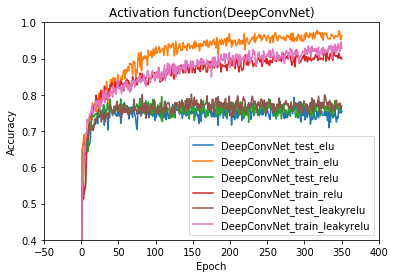

In [15]:
import numpy as np
import matplotlib.pyplot as plt

for i in Results:
    print(i,"       ",max(Results[i]))
# plot the data
fig = plt.figure()
x = np.arange(0, 351, 1)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, Results['DeepConvNet_test_elu'], color='tab:blue',label='DeepConvNet_test_elu')
ax.plot(x, Results['DeepConvNet_train_elu'], color='tab:orange',label='DeepConvNet_train_elu')
ax.plot(x, Results['DeepConvNet_test_relu'], color='tab:green',label='DeepConvNet_test_relu')
ax.plot(x, Results['DeepConvNet_train_relu'], color='tab:red',label='DeepConvNet_train_relu')
ax.plot(x, Results['DeepConvNet_test_leakyrelu'], color='tab:brown',label='DeepConvNet_test_leakyrelu')
ax.plot(x, Results['DeepConvNet_train_leakyrelu'], color='tab:pink',label='DeepConvNet_train_leakyrelu')
# set the limits
ax.set_xlim([-50, 400])
ax.set_ylim([0.4, 1])

ax.set_title('Activation function(DeepConvNet)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
# display the plot
plt.show()

In [ ]:
depconvnet = DeepConvNet_leakyrelu().cuda()
#Optimizer = torch.optim.Adam(depconvnet.parameters(), lr=0.003708909)   # optimize all cnn parameters
Optimizer = torch.optim.RMSprop(depconvnet.parameters(), lr=0.001, alpha=0.9)
Loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
test_label_t = test_label_t.long().cuda()
#Optimizer
Optimizer.zero_grad()
depconvnett = depconvnet.double()
test_result = [0]
train_result = [0]
for epoch in range(5000):
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        b_x = b_x.cuda()
        output = depconvnet(b_x)
        b_y = b_y.long().cuda()
        loss = Loss_func(output, b_y)   # cross entropy loss
        s1 =  torch.squeeze(b_y)
        s2 =  torch.squeeze(output)
        Optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        Optimizer.step()                # apply gradients
    
    a = 0
    b = 0
    for step, (b_x, b_y) in enumerate(test_dataloader):
        pred_y = depconvnet(b_x) 
        pred_y = torch.max(pred_y, 1)[1].cuda().data.squeeze() 
        pred_y = pred_y.double()
        a += float(torch.sum(pred_y == b_y)) 
        b += pred_y.size(0)
    test_result.append(a/b)
    a = 0
    b = 0
    for step, (b_x, b_y) in enumerate(train_dataloader): 
        pred_y = depconvnet(b_x) 
        pred_y = torch.max(pred_y, 1)[1].cuda().data.squeeze() 
        pred_y = pred_y.double()
        a += float(torch.sum(pred_y == b_y))
        b += pred_y.size(0)
    train_result.append(a/b)
    if(epoch%30==0):
        print(epoch,test_result[-1],train_result[-1])

        
Results['DeepConvNet_train_leakyrelu'] = train_result
Results['DeepConvNet_test_leakyrelu'] = test_result

0 0.6407407407407407 0.6268518518518519
30 0.7703703703703704 0.8287037037037037
60 0.7657407407407407 0.862037037037037
90 0.7759259259259259 0.9
120 0.774074074074074 0.912962962962963
150 0.7759259259259259 0.9212962962962963
180 0.7805555555555556 0.9361111111111111
210 0.7851851851851852 0.9435185185185185
240 0.7768518518518519 0.9629629629629629
270 0.7833333333333333 0.9601851851851851
300 0.7842592592592592 0.975
330 0.7851851851851852 0.9648148148148148
360 0.7814814814814814 0.9703703703703703
390 0.7694444444444445 0.9731481481481481
